In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
import torch.nn.functional as F
import torchvision
from pylab import *
import re
from PIL import ImageOps
import itertools
import functools
import operator
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from torch.optim import lr_scheduler




/Users/cameronhudson/Documents/Masters/Research/Snow/snow/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data = pd.read_csv('data/LH_KPCA_5_highRes.csv').drop(columns='mass')
data['shapes'] = (data['shapes']).astype(np.float32)
data['diameter'] = (data['diameter']).astype(np.float32)
data['fall_velocity'] = (data['fall_velocity']).astype(np.float32)
data['air_density'] = (data['air_density']).astype(np.float32)
data['Reynolds Number'] = (data['Reynolds Number']).astype(np.float32)
data['KPCA1'] = (data['KPCA1']).astype(np.float32)
data['KPCA2'] = (data['KPCA2']).astype(np.float32)
data['KPCA3'] = (data['KPCA3']).astype(np.float32)
data['KPCA4'] = (data['KPCA4']).astype(np.float32)
data['KPCA5'] = (data['KPCA5']).astype(np.float32)


# target = pd.read_csv('data/target.csv')
# data = X_data.merge(target, how='inner', on='Unnamed: 0')
data = data.drop(columns=['Unnamed: 0'])
data['Drag Coefficient'] = (data['Drag Coefficient']).astype(np.float32)
data = data.drop([data.index[110]], inplace=False).reset_index().drop(columns='index') # has drag > 4
data['Re_unscaled'] = data['Reynolds Number']
data['id'] = data.index

scaler = StandardScaler()


#data[['Reynolds Number', 'KPCA1', 'KPCA2', 'KPCA3']] = scaler.fit_transform(data[['Reynolds Number', 'KPCA1', 'KPCA2', 'KPCA3']])

data[['Reynolds Number', 'KPCA1', 'KPCA2', 'KPCA3', 'KPCA4', 'KPCA5']] = scaler.fit_transform(data[['Reynolds Number', 'KPCA1', 'KPCA2', 'KPCA3', 'KPCA4', 'KPCA5']])

low_X = (data[data['Re_unscaled'] <= 158]) # 158
high_X = (data[data['Re_unscaled'] > 158]) # 159


low_X = low_X.reset_index()
high_X = high_X.reset_index()


In [7]:
data

,Drag Coefficient,diameter,fall_velocity,air_density,air_viscosity,Reynolds Number,shapes,KPCA1,KPCA2,KPCA3,KPCA4,KPCA5,Re_unscaled,id
0,1.509814,0.002136,1.03,1.112,0.000018,-0.398748,14.0,-0.922873,-0.129363,-1.203811,-0.715664,-0.711141,139.155777,0
1,0.772313,0.002055,1.93,1.112,0.000018,0.366882,14.0,-0.327650,0.041418,-0.513190,1.921389,0.937523,250.869568,1
2,0.460777,0.003011,2.54,1.112,0.000018,1.963325,14.0,1.291081,2.139721,0.670459,-0.271142,-0.704974,483.808044,2
3,0.354451,0.001646,2.01,1.112,0.000018,0.082010,14.0,-1.181696,0.780322,-0.788736,-1.388361,-0.707767,209.303650,3
4,0.644595,0.006918,1.69,1.112,0.000018,3.715550,6.0,-0.060557,2.328631,-0.634736,-0.828193,0.288347,739.476929,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,1.997184,0.001798,1.00,1.112,0.000018,-0.573058,14.0,-1.095075,-0.317799,0.604626,-0.644431,1.201607,113.722054,122
123,0.472535,0.001990,2.30,1.112,0.000018,0.632141,15.0,-0.653439,-1.199220,-0.784993,0.878990,-0.070745,289.573761,123
124,0.994761,0.004031,1.40,1.112,0.000018,1.093994,3.0,0.481949,1.228456,-0.001846,-0.691085,2.759533,356.963135,124
125,0.784335,0.001575,1.20,1.112,0.000018,-0.533126,13.0,1.023146,0.789093,-0.963814,0.567416,0.604715,119.548500,125


In [5]:
len(low_X)

65

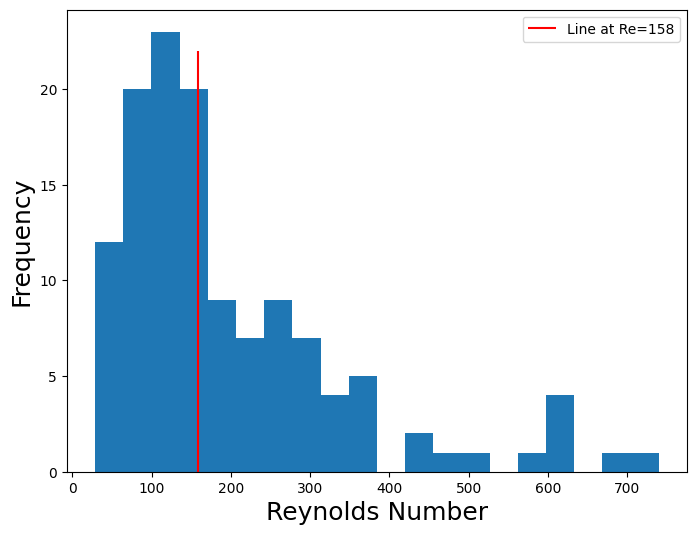

In [23]:
plt.figure(figsize=(8, 6))
plt.hist(data['Re_unscaled'], bins=20)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Reynolds Number', fontsize=18)
plt.vlines(x=158, ymin=0, ymax=22, color='r', label='Line at Re=158')
plt.legend()

In [7]:
batch_size = 8
learning_rate = 1e-3 # 1e-2
num_epochs = 2000

In [8]:
class LH_low(torch.utils.data.Dataset):
    def __init__(self, low_X):

        self.RE = low_X['Reynolds Number']
        self.shape = low_X['shapes']
        self.PCA1 = low_X['KPCA1']
        self.PCA2 = low_X['KPCA2']
        self.PCA3 = low_X['KPCA3']
        self.PCA4 = low_X['KPCA4']
        self.PCA5 = low_X['KPCA5']
        self.y = low_X['Drag Coefficient']
        self.id = low_X['id']

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        RE = torch.tensor(self.RE[idx], dtype=torch.float32)
        shape = torch.tensor(self.shape[idx], dtype=torch.float32)
        PCA1 = torch.tensor(self.PCA1[idx], dtype=torch.float32)
        PCA2 = torch.tensor(self.PCA2[idx], dtype=torch.float32)
        PCA3 = torch.tensor(self.PCA3[idx], dtype=torch.float32)
        PCA4 = torch.tensor(self.PCA4[idx], dtype=torch.float32)
        PCA5 = torch.tensor(self.PCA5[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        id = torch.tensor(self.id[idx], dtype=torch.float32)
        
       # return data, y
        #return torch.tensor([RE, shape]), y, id
        return torch.tensor([RE, shape, PCA1, PCA2, PCA3, PCA4, PCA5]), y, id

class LH_high(torch.utils.data.Dataset):
    def __init__(self, high_X):

        self.RE = high_X['Reynolds Number']
        self.shape = high_X['shapes']
        self.PCA1 = high_X['KPCA1']
        self.PCA2 = high_X['KPCA2']
        self.PCA3 = high_X['KPCA3']
        self.PCA4 = high_X['KPCA4']
        self.PCA5 = high_X['KPCA5']
        self.y = high_X['Drag Coefficient']
        self.id = high_X['id']

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        RE = torch.tensor(self.RE[idx], dtype=torch.float32)
        shape = torch.tensor(self.shape[idx], dtype=torch.float32)
        PCA1 = torch.tensor(self.PCA1[idx], dtype=torch.float32)
        PCA2 = torch.tensor(self.PCA2[idx], dtype=torch.float32)
        PCA3 = torch.tensor(self.PCA3[idx], dtype=torch.float32)
        PCA4 = torch.tensor(self.PCA4[idx], dtype=torch.float32)
        PCA5 = torch.tensor(self.PCA5[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        id = torch.tensor(self.id[idx], dtype=torch.float32)
        
       # return data, y
        #return torch.tensor([RE, shape]), y, id
        return torch.tensor([RE, shape, PCA1, PCA2, PCA3, PCA4, PCA5]), y, id


In [9]:
low_data = LH_low(low_X)
train_size_low = int(0.75 * len(low_data))
test_size_low = len(low_data) - train_size_low
train_dataset_low, test_dataset_low = torch.utils.data.random_split(low_data, [train_size_low, test_size_low])

train_loader_low = DataLoader(train_dataset_low, batch_size=batch_size, shuffle=True)
test_loader_low = DataLoader(test_dataset_low, batch_size=batch_size)

# ---------------------------------------------------------------------------------

high_data = LH_high(high_X)
train_size_high = int(0.75 * len(high_data))
test_size_high = len(high_data) - train_size_high
train_dataset_high, test_dataset_high = torch.utils.data.random_split(high_data, [train_size_high, test_size_high])

train_loader_high = DataLoader(train_dataset_high, batch_size=batch_size, shuffle=True)
test_loader_high = DataLoader(test_dataset_high, batch_size=batch_size)

In [19]:

class MLP_control_high(nn.Module):
  
  def __init__(self):
    super(MLP_control_high, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(2, 5),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(5, 11),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(11, 23),
      nn.ReLU(),
      nn.Linear(23, 11), 
      nn.ReLU(),
      nn.Linear(11, 5),
      nn.ReLU(),
      nn.Linear(5, 2),
      nn.ReLU(),
      nn.Linear(2, 1),
    )

  def forward(self, x):
    return self.layers(x)  
  


class MLP_control_low(nn.Module):
  
  def __init__(self):
    super(MLP_control_low, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(2, 5),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(5, 11),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(11, 23),
      nn.ReLU(),
      nn.Linear(23, 11), 
      nn.ReLU(),
      nn.Linear(11, 5),
      nn.ReLU(),
      nn.Linear(5, 2),
      nn.ReLU(),
      nn.Linear(2, 1),
    )

  def forward(self, x):
    return self.layers(x)  
  
  
class CombinedModel_control(nn.Module):
  def __init__(self, MLP_control_low, MLP_control_high):
    super(CombinedModel_control, self).__init__()
    self.MLP_control_low = MLP_control_low
    self.MLP_control_high = MLP_control_high
    
  def forward(self, x):
    if x[2] <= 158: # 158
      x = torch.cat((x[:2], x[2+1:]))
      x = self.MLP_control_low(x)
    else:
      x = torch.cat((x[:2], x[2+1:]))
      x = self.MLP_control_high(x)
    return x


In [20]:

class MLP1_high(nn.Module):
  
  def __init__(self):
    super(MLP1_high, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(3, 7),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(7, 15),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(15, 31),
      nn.ReLU(),
      nn.Linear(31, 15), 
      nn.ReLU(),
      nn.Linear(15, 7),
      nn.ReLU(),
      nn.Linear(7, 3),
      nn.ReLU(),
      nn.Linear(3, 1),
    )

  def forward(self, x):
    return self.layers(x)  
  


class MLP1_low(nn.Module):
  
  def __init__(self):
    super(MLP1_low, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(3, 7),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(7, 15),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(15, 31),
      nn.ReLU(),
      nn.Linear(31, 15), 
      nn.ReLU(),
      nn.Linear(15, 7),
      nn.ReLU(),
      nn.Linear(7, 3),
      nn.ReLU(),
      nn.Linear(3, 1),
    )

  def forward(self, x):
    return self.layers(x)  
  
  
class CombinedModel1(nn.Module):
  def __init__(self, MLP1_low, MLP1_high):
    super(CombinedModel1, self).__init__()
    self.MLP1_low = MLP1_low
    self.MLP1_high = MLP1_high
    
  def forward(self, x):
    if x[3] <= 158: # 158
      x = torch.cat((x[:3], x[3+1:]))
      x = self.MLP1_low(x)
    else:
      x = torch.cat((x[:3], x[3+1:]))
      x = self.MLP1_high(x)
    return x


In [21]:
  
class MLP3_high(nn.Module):
  
  def __init__(self):
    super(MLP3_high, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(5, 11),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(11, 23),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(23, 47),
      nn.ReLU(),
      nn.Linear(47, 23), 
      nn.ReLU(),
      nn.Linear(23, 11),
      nn.ReLU(),
      nn.Linear(11, 5),
      nn.ReLU(),
      nn.Linear(5, 1),
    )

  def forward(self, x):
    return self.layers(x)  
  
  
class MLP3_low(nn.Module):
  
  def __init__(self):
    super(MLP3_low, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(5, 11),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(11, 23),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(23, 47),
      nn.ReLU(),
      nn.Linear(47, 23), 
      nn.ReLU(),
      nn.Linear(23, 11),
      nn.ReLU(),
      nn.Linear(11, 5),
      nn.ReLU(),
      nn.Linear(5, 1),
    )

  def forward(self, x):
    return self.layers(x)  
  
class CombinedModel3(nn.Module):
  def __init__(self, MLP3_low, MLP3_high):
    super(CombinedModel3, self).__init__()
    self.MLP3_low = MLP3_low
    self.MLP3_high = MLP3_high
    
  def forward(self, x):
    if x[5] <= 158: # 158
      x = torch.cat((x[:5], x[5+1:]))
      x = self.MLP3_low(x)
    else:
      x = torch.cat((x[:5], x[5+1:]))
      x = self.MLP3_high(x)
    return x

In [12]:
class MLP5_low(nn.Module):

  def __init__(self):
    super(MLP5_low, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(7, 15),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(15, 31),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(31, 63),
      nn.ReLU(),
      nn.Linear(63, 31), 
      nn.ReLU(),
      nn.Linear(31, 15),
      nn.ReLU(),
      nn.Linear(15, 7),
      nn.ReLU(),
      nn.Linear(7, 1),
    )

  def forward(self, x):
    return self.layers(x)  
    
    

class MLP5_high(nn.Module):

  def __init__(self):
    super(MLP5_high, self).__init__()
    self.layers = nn.Sequential(
      nn.Linear(7, 15),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(15, 31),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(31, 63),
      nn.ReLU(),
      nn.Linear(63, 31), 
      nn.ReLU(),
      nn.Linear(31, 15),
      nn.ReLU(),
      nn.Linear(15, 7),
      nn.ReLU(),
      nn.Linear(7, 1),
    )

  def forward(self, x):
    return self.layers(x)  

  
class CombinedModel(nn.Module):
  def __init__(self, MLP5_low, MLP5_high):
    super(CombinedModel, self).__init__()
    self.MLP5_low = MLP5_low
    self.MLP5_high = MLP5_high
    
  def forward(self, x):
    if x[7] <= 158: # 158
      x = torch.cat((x[:7], x[7+1:]))
      x = self.MLP5_low(x)
    else:
      x = torch.cat((x[:7], x[7+1:]))
      x = self.MLP5_high(x)
    return x

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Defining our model and training our model

lr_step_size = 500
lr_gamma = 0.5

model_low = MLP5_low().to(device)  # Create an instance of the model
model_high = MLP5_high().to(device)  
#optimizer =  torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # Choose an optimizer
optimizer_low = torch.optim.Adam(model_low.parameters(), lr=learning_rate)
optimizer_high = torch.optim.Adam(model_high.parameters(), lr=learning_rate)
criterion = nn.MSELoss()  # Mean squared error loss
scheduler_low = lr_scheduler.StepLR(optimizer_low, step_size=lr_step_size, gamma=lr_gamma)
scheduler_high = lr_scheduler.StepLR(optimizer_high, step_size=lr_step_size, gamma=lr_gamma)


train_loss_list_low = []
test_loss_list_low = []

train_loss_list_high = []
test_loss_list_high = []

best_test_MSE_low = 100
best_test_MSE_high = 100
# Training loop 

for epoch in range(num_epochs):
    model_low.train()  # Set the model in training mode
    train_loss = 0.0
    scheduler_low.step()

    for X, y, _ in train_loader_low:

        X = Variable(X, requires_grad=True)
        y = Variable(y)
        # Forward pass
        outputs = model_low(X)
        loss = criterion(outputs, y)
       
        # Backward pass and optimization
        optimizer_low.zero_grad() 
        loss.backward()
        optimizer_low.step()

        train_loss += loss.item()

    train_loss /= len(train_loader_low.dataset)
    train_loss_list_low.append(train_loss)
    # Evaluation
    model_low.eval()  # Set the model in evaluation mode
    test_loss = 0.0

    with torch.no_grad():
        for X, y, _ in test_loader_low:

            X = Variable(X, requires_grad=True)
            y = Variable(y)
            
            # Forward pass
            outputs = model_low(X)
            loss = criterion(outputs[0], y)
        
            # Backward pass and optimization
            # optimizer_low.zero_grad() 
            # loss.backward()
            # optimizer_low.step()

            test_loss += loss.item()

    test_loss /= len(test_loader_low.dataset)
    test_loss_list_low.append(test_loss)
    
    if test_loss < best_test_MSE_low:
        best_test_MSE_low = test_loss
        best_model_state_low = model_low.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f} - Test Loss: {test_loss:.6f}")

torch.save(best_model_state_low, '/Users/cameronhudson/Documents/Masters/Research/Snow/LH_models/testlow.model')


for epoch in range(num_epochs):
    model_high.train()  # Set the model in training mode
    train_loss = 0.0
    scheduler_high.step()

    for X, y, _ in train_loader_high:

        X = Variable(X, requires_grad=True)
        y = Variable(y)
        # Forward pass
        outputs = model_high(X)
        loss = criterion(outputs, y)
       
        # Backward pass and optimization
        optimizer_high.zero_grad() 
        loss.backward()
        optimizer_high.step()

        train_loss += loss.item()

    train_loss /= len(train_loader_high.dataset)
    train_loss_list_high.append(train_loss)
    # Evaluation
    model_low.eval()  # Set the model in evaluation mode
    test_loss = 0.0

    with torch.no_grad():
        for X, y, _ in test_loader_high:

            X = Variable(X, requires_grad=True)
            y = Variable(y)
            
            # Forward pass
            outputs = model_high(X)
            loss = criterion(outputs[0], y)
        
            # Backward pass and optimization
            # optimizer_high.zero_grad() 
            # loss.backward()
            # optimizer_high.step()

            test_loss += loss.item()

    test_loss /= len(test_loader_high.dataset)
    test_loss_list_high.append(test_loss)

    if test_loss < best_test_MSE_high:
        best_test_MSE_high = test_loss
        best_model_state_high = model_high.state_dict()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f} - Test Loss: {test_loss:.6f}")

torch.save(best_model_state_high, '/Users/cameronhudson/Documents/Masters/Research/Snow/LH_models/testhigh.model')

torch.save(test_loader_low, '/Users/cameronhudson/Documents/Masters/Research/Snow/LH_models/testloader_low.pth')
torch.save(test_loader_high, '/Users/cameronhudson/Documents/Masters/Research/Snow/LH_models/testloader_high.pth')

Epoch 1/2000 - Train Loss: 0.250979 - Test Loss: 0.283098
Epoch 2/2000 - Train Loss: 0.231495 - Test Loss: 0.259113
Epoch 3/2000 - Train Loss: 0.213975 - Test Loss: 0.240196
Epoch 4/2000 - Train Loss: 0.195901 - Test Loss: 0.215403
Epoch 5/2000 - Train Loss: 0.168365 - Test Loss: 0.178137
Epoch 6/2000 - Train Loss: 0.137275 - Test Loss: 0.124642
Epoch 7/2000 - Train Loss: 0.080230 - Test Loss: 0.065402
Epoch 8/2000 - Train Loss: 0.067978 - Test Loss: 0.038688
Epoch 9/2000 - Train Loss: 0.057244 - Test Loss: 0.039484
Epoch 10/2000 - Train Loss: 0.066455 - Test Loss: 0.047405
Epoch 11/2000 - Train Loss: 0.059667 - Test Loss: 0.053367
Epoch 12/2000 - Train Loss: 0.055439 - Test Loss: 0.045634
Epoch 13/2000 - Train Loss: 0.054744 - Test Loss: 0.044879
Epoch 14/2000 - Train Loss: 0.053857 - Test Loss: 0.043307
Epoch 15/2000 - Train Loss: 0.051653 - Test Loss: 0.048234
Epoch 16/2000 - Train Loss: 0.053934 - Test Loss: 0.048391
Epoch 17/2000 - Train Loss: 0.053147 - Test Loss: 0.044329
Epoch 

/Users/cameronhudson/Documents/Masters/Research/Snow/snow/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/2000 - Train Loss: 0.016651 - Test Loss: 0.024045
Epoch 11/2000 - Train Loss: 0.016924 - Test Loss: 0.024078
Epoch 12/2000 - Train Loss: 0.016535 - Test Loss: 0.022797
Epoch 13/2000 - Train Loss: 0.016861 - Test Loss: 0.022447
Epoch 14/2000 - Train Loss: 0.016096 - Test Loss: 0.027477
Epoch 15/2000 - Train Loss: 0.016585 - Test Loss: 0.020217
Epoch 16/2000 - Train Loss: 0.015009 - Test Loss: 0.021392
Epoch 17/2000 - Train Loss: 0.014934 - Test Loss: 0.023123
Epoch 18/2000 - Train Loss: 0.015409 - Test Loss: 0.020795
Epoch 19/2000 - Train Loss: 0.015441 - Test Loss: 0.023181
Epoch 20/2000 - Train Loss: 0.014967 - Test Loss: 0.023928
Epoch 21/2000 - Train Loss: 0.015303 - Test Loss: 0.026279
Epoch 22/2000 - Train Loss: 0.015447 - Test Loss: 0.021696
Epoch 23/2000 - Train Loss: 0.015135 - Test Loss: 0.024535
Epoch 24/2000 - Train Loss: 0.014775 - Test Loss: 0.022148
Epoch 25/2000 - Train Loss: 0.014973 - Test Loss: 0.022487
Epoch 26/2000 - Train Loss: 0.014433 - Test Loss: 0.0225

In [13]:
modelLow = MLP5_low()
modelHigh = MLP5_high()
 # LH_low_5k_sch_dropout
low = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_models/LH_low_5k_sch_dropout.model') # improving1 is hte best # then 25k filtered # low1_MLP3 best for 3
high = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_models/LH_high_5k_sch_dropout.model')
modelLow.load_state_dict(low)
modelHigh.load_state_dict(high)

test_loader_low = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_models/LH_low_5k_sch_testloader_dropout.pth') # LH_low_5k_sch_testloader_dropout
test_loader_high = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_models/LH_high_5k_sch_testloader_dropout.pth')

modelCombined = CombinedModel(modelLow, modelHigh)

In [14]:
y_test_low = [dat.item() for data in test_loader_low for dat in data[1]]
y_test_high = [dat.item() for data in test_loader_high for dat in data[1]]
y_test = y_test_low + y_test_high

low_data = [dat for data in test_loader_low for dat in data[0]]
high_data = [dat for data in test_loader_high for dat in data[0]]

combined_data = low_data + high_data

y_test_ids_high = [dat.item() for data in test_loader_high for dat in data[2]]
y_test_ids_low = [dat.item() for data in test_loader_low for dat in data[2]]
y_test_ids = y_test_ids_low + y_test_ids_high

LH_test = data.loc[y_test_ids]

full_LH = pd.read_csv('/Users/cameronhudson/Documents/Masters/Research/Snow/data/LHDataClean.csv')
full_LH = full_LH[['Mass [kg]', 'Drag Coefficient']]
full_LH['Drag Coefficient'] = (full_LH['Drag Coefficient']).astype(np.float32)

LH_test = pd.merge(LH_test, full_LH, on='Drag Coefficient', how='left')

#testing_data = LH_test[['Reynolds Number', 'shapes', 'Re_unscaled']]
testing_data = LH_test[['Reynolds Number', 'shapes', 'KPCA1', 'KPCA2', 'KPCA3', 'KPCA4', 'KPCA5', 'Re_unscaled']]
testing_data = [torch.tensor(row.values) for _, row in testing_data.iterrows()]

y_pred = []
for i in testing_data:
    y_pred.append(modelCombined(i).item())

LH_test['y_pred'] = y_pred

In [15]:
print('Our Model: ' + str(np.mean([abs(i-j)**2 for i,j in zip(y_pred, y_test)])))

Our Model: 0.17563787454106863


In [16]:
print('Our Model: ' + str(np.mean([abs(i-j)**2 for i,j in zip(y_pred, y_test)])))

Our Model: 0.17563787454106863


In [72]:
mse = []
for _ in range(100):
    y_pred = []
    for i in testing_data:
        y_pred.append(modelCombined(i).item())

    mse.append(np.mean([abs(i-j)**2 for i,j in zip(y_pred, y_test)]))

In [73]:
np.mean(mse)

0.20671916938893872

In [1]:
min(mse)

NameError: name 'mse' is not defined

Text(0, 0.5, 'y_prediction from model')

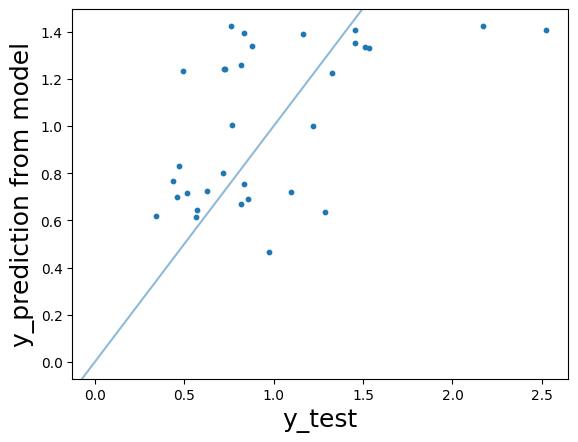

In [17]:
plt.scatter(LH_test['Drag Coefficient'], y_pred, s=10)
plt.axline((0, 0), slope=1, alpha=0.5)
plt.xlabel('y_test',  fontsize=18)
plt.ylabel('y_prediction from model',  fontsize=18) # fe_5_e4"
#plt.title('LH Dataset Drag Prediction vs Drag Coefficient on Test Dataset')

Text(0, 0.5, 'y_prediction from model')

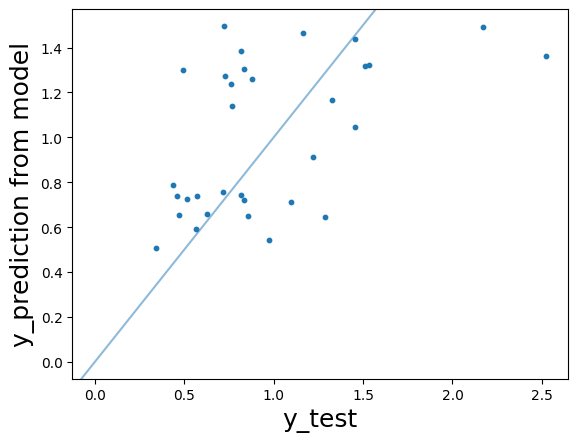

In [76]:
plt.scatter(LH_test['Drag Coefficient'], y_pred, s=10)
plt.axline((0, 0), slope=1, alpha=0.5)
plt.xlabel('y_test',  fontsize=18)
plt.ylabel('y_prediction from model',  fontsize=18) # fe_5_e4"
#plt.title('LH Dataset Drag Prediction vs Drag Coefficient on Test Dataset')

Text(0.5, 1.0, 'LH Dataset Drag Prediction vs Drag Coefficient on Test Dataset')

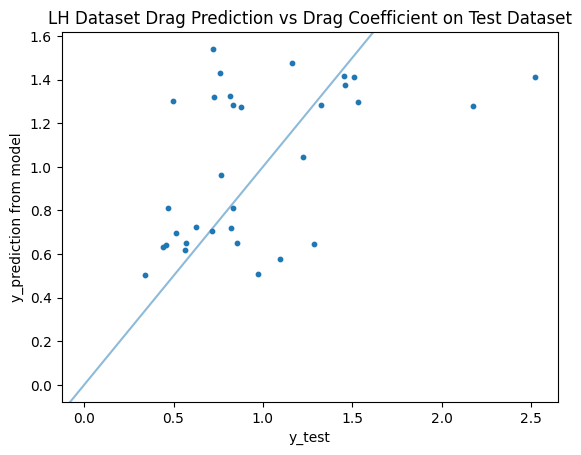

In [500]:
plt.scatter(LH_test['Drag Coefficient'], y_pred, s=10)
plt.axline((0, 0), slope=1, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_prediction from model') # fe_5_e4"
plt.title('LH Dataset Drag Prediction vs Drag Coefficient on Test Dataset')

Text(0.5, 1.0, 'LH Dataset Drag Prediction vs Drag Coefficient on Test Dataset')

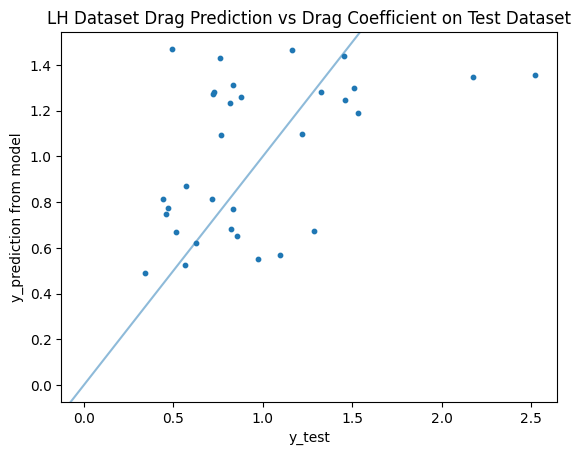

In [264]:
plt.scatter(LH_test['Drag Coefficient'], y_pred, s=10)
plt.axline((0, 0), slope=1, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_prediction from model') # fe_5_e4"
plt.title('LH Dataset Drag Prediction vs Drag Coefficient on Test Dataset')

Text(0, 0.5, 'y_prediction from model')

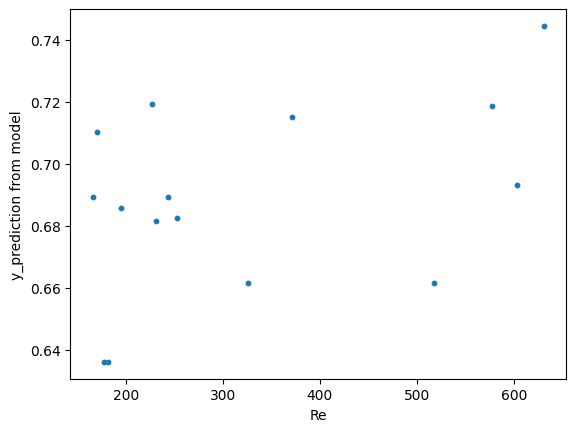

In [114]:
issues = LH_test[LH_test['y_pred'] < 0.9]

plt.scatter(issues['Re_unscaled'], issues['y_pred'], s=10)
plt.xlabel('Re')
plt.ylabel('y_prediction from model') # fe_5_e4"

Text(0, 0.5, 'Prediction Error')

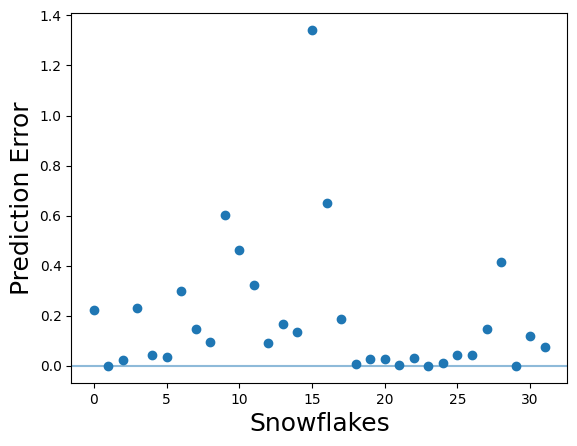

In [78]:
error = []
for i in range(len(y_test)):
    error.append(float(y_test[i] - y_pred[i])**2)

plt.scatter([i for i in range(len(error))], error)
plt.axline((0,0), slope=0, alpha=0.5)
plt.xlabel('Snowflakes', fontsize=18)
plt.ylabel('Prediction Error', fontsize=18)
#plt.title('LH Prediction Model on Drag Error Graph')

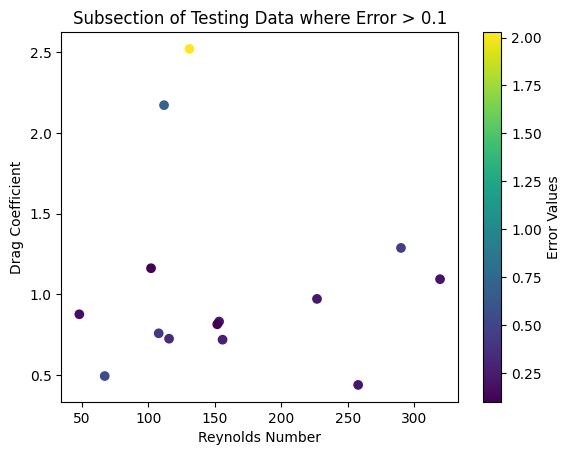

In [44]:
LH_test['error'] = error
errors_test = LH_test[LH_test['error'] > 0.1]

scatter = plt.scatter(errors_test['Re_unscaled'], errors_test['Drag Coefficient'], c=errors_test['error'])
plt.xlabel('Reynolds Number')
plt.ylabel('Drag Coefficient')
cbar = plt.colorbar(scatter)
cbar.set_label('Error Values')
plt.title('Subsection of Testing Data where Error > 0.1')
plt.show()

In [325]:
shape_dict = {'shapeClass' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16],
              'shapeName' : ['bALP7a', 'bALS3', 'bAP7a', 'bAR2b', 'bAS3', 'bHP7b', 'bR1a', 'bR1b', 'bR2a', 'bR2b', 'rR3a', 'bR3b', 'bR4a', 'bR4b', 'bR4c', 'unknown']}
shape_df = pd.DataFrame(shape_dict)

shape_mapping = dict(zip(shape_df['shapeClass'], shape_df['shapeName']))

LH_test['shape_names'] = [shape_mapping[int_val] for int_val in LH_test['shapes']]

(array([2., 4., 3., 5., 6., 1., 1., 1., 2., 1., 4., 0., 0., 0., 0., 0., 1.,
        0., 0., 1.]),
 array([0.34235644, 0.4513067 , 0.56025696, 0.66920727, 0.77815753,
        0.88710779, 0.99605805, 1.10500836, 1.21395862, 1.32290888,
        1.43185914, 1.54080939, 1.64975965, 1.75870991, 1.86766016,
        1.97661042, 2.0855608 , 2.19451094, 2.30346131, 2.41241145,
        2.52136183]),
 <BarContainer object of 20 artists>)

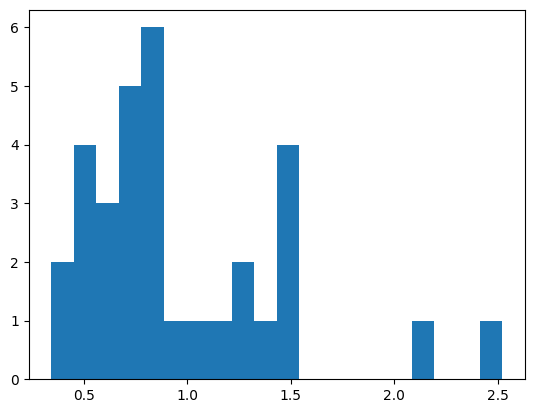

In [308]:
plt.hist(LH_test['Drag Coefficient'], bins=20)

In [18]:
C0HW = 0.35 # Mitchell 1996 C0 = 0.6 and delta0 = 5.83
del0HW = 8.0 # HW (2010) C0 = 0.35 and delta0 = 8.0
k = 0.5

CdHW_init = [C0HW * (1 + del0HW / np.sqrt(Re_val))**2 for Re_val in LH_test['Re_unscaled']]

LH_test['area'] = (LH_test['Mass [kg]'] * 9.81) / (0.5*LH_test['air_density'] * LH_test['fall_velocity']**2*LH_test['Drag Coefficient'])
LH_test['Ar'] = LH_test['area']/(((np.pi)/4)*LH_test['diameter']**2)

CdHW = (LH_test['Ar']**k) * CdHW_init


Text(0.5, 1.0, 'Heymsfield and Westbrook and Drag Prediction Model')

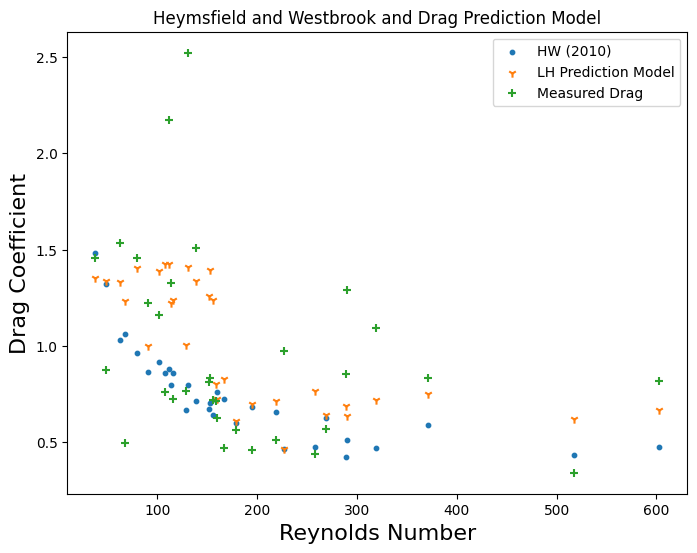

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(LH_test['Re_unscaled'], CdHW, s=10)
plt.scatter(LH_test['Re_unscaled'], y_pred,marker="1")
plt.scatter(LH_test['Re_unscaled'], LH_test['Drag Coefficient'], marker='+')
plt.legend(['HW (2010)','LH Prediction Model', 'Measured Drag'])
plt.xlabel('Reynolds Number', fontsize=16)
plt.ylabel('Drag Coefficient', fontsize=16)
plt.ylim((0,2.5))
plt.title('Heymsfield and Westbrook and Drag Prediction Model')

Text(0.5, 1.0, 'HW (2010) and LH Drag Prediction Model vs Reynolds Number')

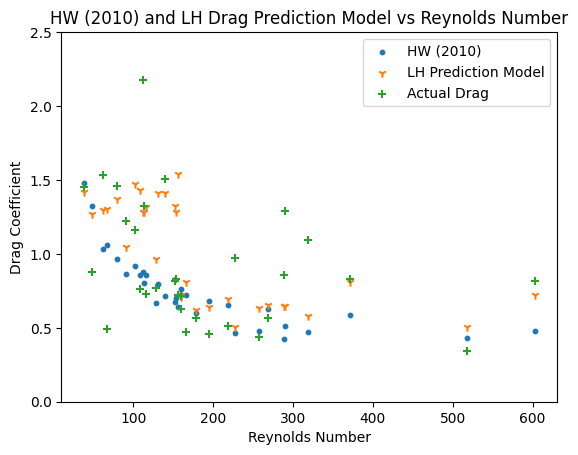

In [507]:
plt.scatter(LH_test['Re_unscaled'], CdHW, s=10)
plt.scatter(LH_test['Re_unscaled'], y_pred,marker="1")
plt.scatter(LH_test['Re_unscaled'], LH_test['Drag Coefficient'], marker='+')
plt.legend(['HW (2010)','LH Prediction Model', 'Actual Drag'])
plt.xlabel('Reynolds Number')
plt.ylabel('Drag Coefficient')
plt.ylim((0,2.5))
plt.title('HW (2010) and LH Drag Prediction Model vs Reynolds Number')

In [25]:
geom_LH = pd.read_csv('/Users/cameronhudson/Documents/Masters/Research/Snow/data/LH_geom_out.csv')
LH_test = pd.merge(LH_test, geom_LH, on='id', how='left')

HS = [(8/Re)*(1/np.sqrt(length_sph)) + (16/Re)*(1/np.sqrt(sph)) + (3/np.sqrt(Re))*(1/(sph**(3/4))) + 0.4210**(0.4*(-np.log(sph))**0.2)*(1/cross_sph) for Re, sph, length_sph, cross_sph
      in zip(LH_test['Re_unscaled'], LH_test['sphericity'], LH_test['length_sph'], LH_test['cross_sph'])]

HS = [val / 2 for val in HS]

Text(0.5, 1.0, 'Holzer and Sommerfeld and Drag Prediction Model')

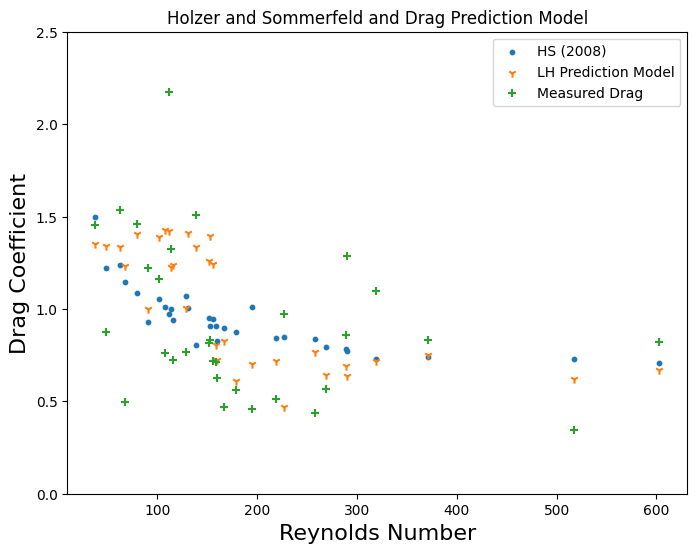

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(LH_test['Re_unscaled'], HS, s=10)
plt.scatter(LH_test['Re_unscaled'], y_pred,marker="1")
plt.scatter(LH_test['Re_unscaled'], LH_test['Drag Coefficient'], marker='+')
plt.legend(['HS (2008)','LH Prediction Model', 'Measured Drag'])
plt.xlabel('Reynolds Number', fontsize=16)
plt.ylabel('Drag Coefficient', fontsize=16)
plt.ylim((0,2.5))
plt.title('Holzer and Sommerfeld and Drag Prediction Model')

Text(0.5, 1.0, 'HS (2008) and LH Drag Prediction Model vs Reynolds Number')

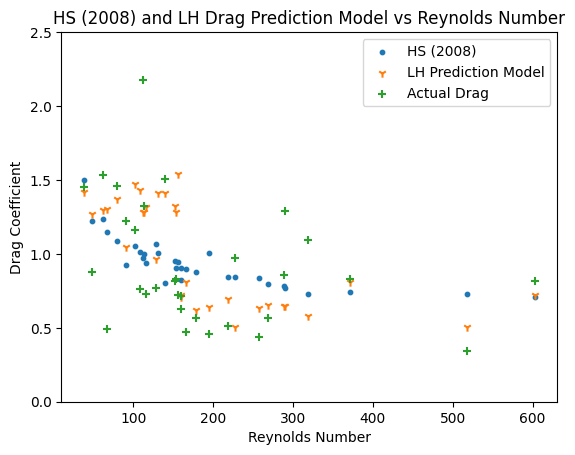

In [505]:
plt.scatter(LH_test['Re_unscaled'], HS, s=10)
plt.scatter(LH_test['Re_unscaled'], y_pred,marker="1")
plt.scatter(LH_test['Re_unscaled'], LH_test['Drag Coefficient'], marker='+')
plt.legend(['HS (2008)','LH Prediction Model', 'Actual Drag'])
plt.xlabel('Reynolds Number')
plt.ylabel('Drag Coefficient')
plt.ylim((0,2.5))
plt.title('HS (2008) and LH Drag Prediction Model vs Reynolds Number')

In [27]:
kS_ganser = [1/3 + 2/3 * np.sqrt(sph) for sph in LH_test['sphericity']]
kS_leith = [1/3*np.sqrt(cross_sph) + 2/3 * np.sqrt(sph) for cross_sph, sph in zip(LH_test['cross_sph'], LH_test['sphericity'])] # Leith
kN_ganser = [10**(1.8148*(-np.log(sph))**0.5743) for sph in LH_test['sphericity']]
LH_test['kS_ganser'] = kS_ganser
LH_test['kS_leith'] = kS_leith
LH_test['kN_ganser'] = kN_ganser


cdGanser = [(24*kS)/Re * (1 + 0.1118*((Re*kN)/kS)**0.6567) + (0.4305*kN)/(1+(3305/((Re*kN)/kS))) for kS, kN, Re in zip(LH_test['kS_ganser'], LH_test['kN_ganser'], LH_test['Re_unscaled'])]
cdGanser_w_Leith_kS = [(24*kS)/Re * (1 + 0.1118*((Re*kN)/kS)**0.6567) + (0.4305*kN)/(1+(3305/((Re*kN)/kS))) for kS, kN, Re in zip(LH_test['kS_leith'], LH_test['kN_ganser'], LH_test['Re_unscaled'])]

cdGanser = [val / 4 for val in cdGanser]
cdGanser_w_Leith_kS = [val / 4 for val in cdGanser_w_Leith_kS]

Text(0.5, 1.0, 'Ganser and Drag Prediction Model')

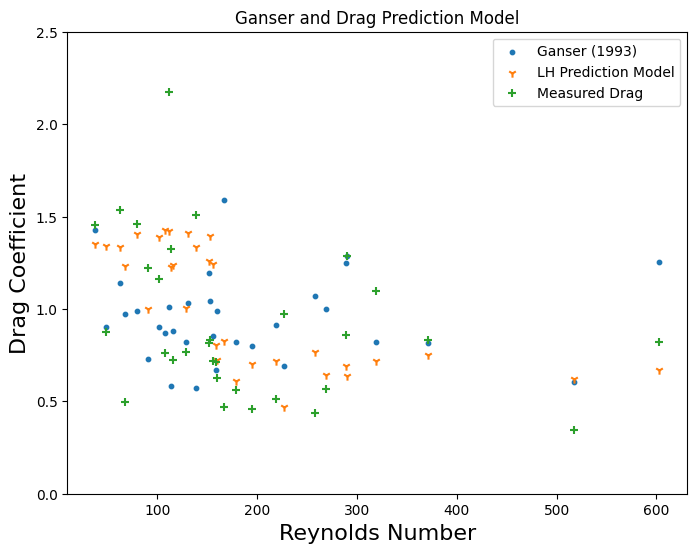

In [28]:
plt.figure(figsize=(8, 6))
plt.scatter(LH_test['Re_unscaled'], cdGanser, s=10)
plt.scatter(LH_test['Re_unscaled'], y_pred,marker="1")
plt.scatter(LH_test['Re_unscaled'], LH_test['Drag Coefficient'], marker='+')
plt.legend(['Ganser (1993)','LH Prediction Model', 'Measured Drag'])
plt.xlabel('Reynolds Number', fontsize=16)
plt.ylabel('Drag Coefficient', fontsize=16)
plt.ylim((0,2.5))
plt.title('Ganser and Drag Prediction Model')

Text(0.5, 1.0, 'Ganser (1993) and LH Drag Prediction Model vs Reynolds Number')

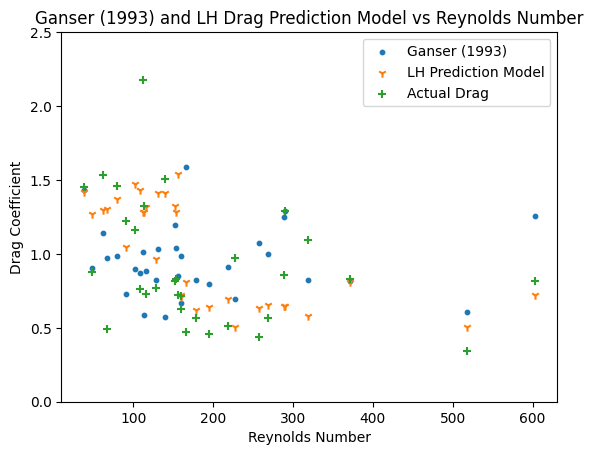

In [509]:
plt.scatter(LH_test['Re_unscaled'], cdGanser, s=10)
plt.scatter(LH_test['Re_unscaled'], y_pred,marker="1")
plt.scatter(LH_test['Re_unscaled'], LH_test['Drag Coefficient'], marker='+')
plt.legend(['Ganser (1993)','LH Prediction Model', 'Actual Drag'])
plt.xlabel('Reynolds Number')
plt.ylabel('Drag Coefficient')
plt.ylim((0,2.5))
plt.title('Ganser (1993) and LH Drag Prediction Model vs Reynolds Number')

Text(0.5, 1.0, 'Ganser w/ Leith kS and Drag Prediction Model')

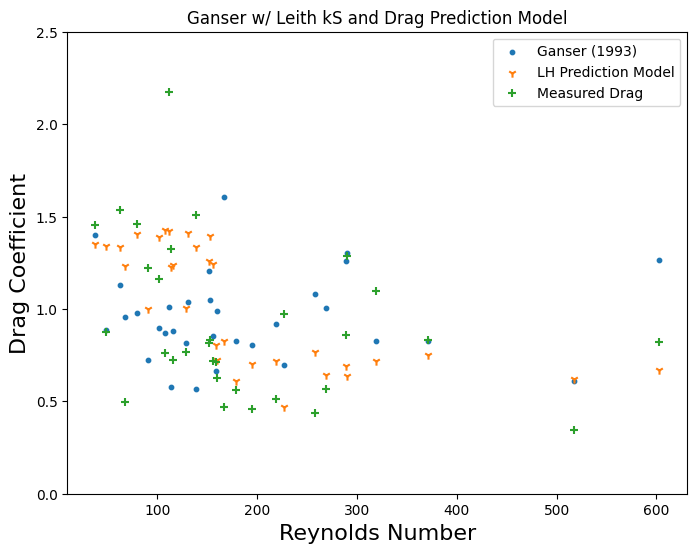

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(LH_test['Re_unscaled'], cdGanser_w_Leith_kS, s=10)
plt.scatter(LH_test['Re_unscaled'], y_pred,marker="1")
plt.scatter(LH_test['Re_unscaled'], LH_test['Drag Coefficient'], marker='+')
plt.legend(['Ganser (1993)','LH Prediction Model', 'Measured Drag'])
plt.xlabel('Reynolds Number', fontsize=16)
plt.ylabel('Drag Coefficient', fontsize=16)
plt.ylim((0,2.5))
plt.title('Ganser w/ Leith kS and Drag Prediction Model')

Text(0.5, 1.0, 'Ganser (1993) w/ Leith kS and LH Drag Prediction Model vs Reynolds Number')

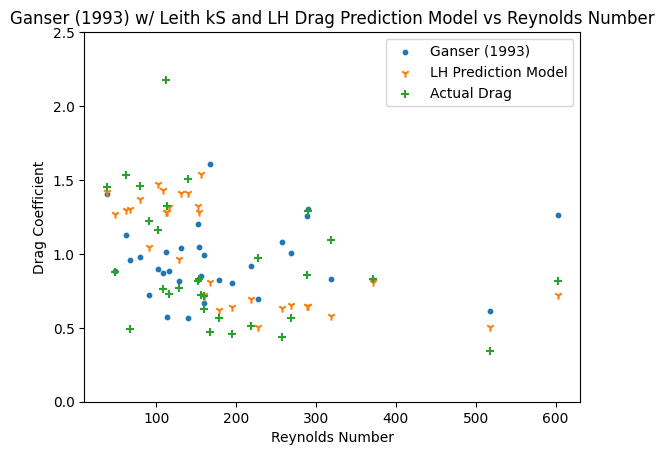

In [510]:
plt.scatter(LH_test['Re_unscaled'], cdGanser_w_Leith_kS, s=10)
plt.scatter(LH_test['Re_unscaled'], y_pred,marker="1")
plt.scatter(LH_test['Re_unscaled'], LH_test['Drag Coefficient'], marker='+')
plt.legend(['Ganser (1993)','LH Prediction Model', 'Actual Drag'])
plt.xlabel('Reynolds Number')
plt.ylabel('Drag Coefficient')
plt.ylim((0,2.5))
plt.title('Ganser (1993) w/ Leith kS and LH Drag Prediction Model vs Reynolds Number')

In [30]:
c1 = [exp(2.3288 - 6.4581*sph + 2.4486*(sph**2)) for sph in LH_test['sphericity']]
c2 = [0.0964 + 0.5565*sph for sph in LH_test['sphericity']]
c3 = [exp(4.905 - 13.8944*sph + 18.4222*(sph**2) - 10.2599*(sph**3)) for sph in LH_test['sphericity']]
c4 = [exp(1.4681 + 12.2584*sph - 20.7322*(sph**2) - 15.8855*(sph**3)) for sph in LH_test['sphericity']]

cdHL = [(24/Re) * (1 + c1*Re**c2) + (Re * c3)/(Re+c4) for Re, c1, c2, c3, c4 in zip(LH_test['Re_unscaled'], c1, c2, c3, c4)]
cdHL = [val / 3 for val in cdHL]

Text(0.5, 1.0, 'Haider and Levenspiel and Drag Prediction Model')

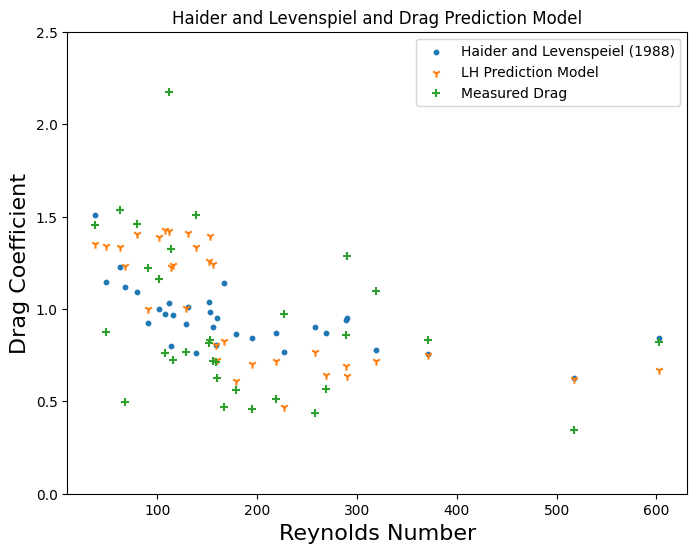

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(LH_test['Re_unscaled'], cdHL, s=10)
plt.scatter(LH_test['Re_unscaled'], y_pred,marker="1")
plt.scatter(LH_test['Re_unscaled'], LH_test['Drag Coefficient'], marker='+')
plt.legend(['Haider and Levenspeiel (1988)','LH Prediction Model', 'Measured Drag'])
plt.xlabel('Reynolds Number', fontsize=16)
plt.ylabel('Drag Coefficient',fontsize=16)
plt.ylim((0,2.5))
plt.title('Haider and Levenspiel and Drag Prediction Model')

Text(0.5, 1.0, 'Haider and Levenspiel (1988) and LH Drag Prediction Model vs Reynolds Number')

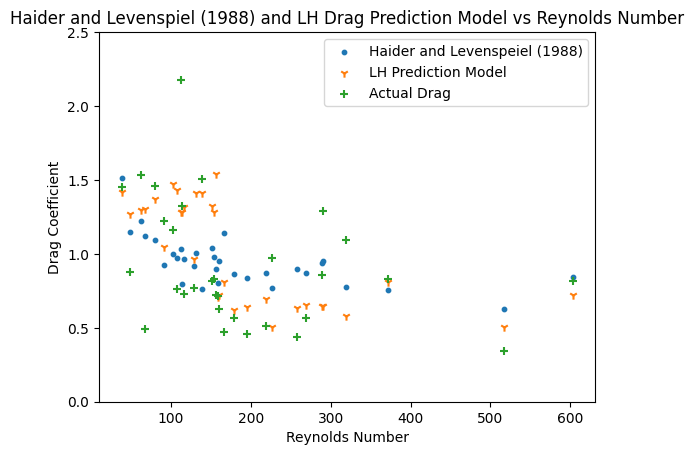

In [514]:
plt.scatter(LH_test['Re_unscaled'], cdHL, s=10)
plt.scatter(LH_test['Re_unscaled'], y_pred,marker="1")
plt.scatter(LH_test['Re_unscaled'], LH_test['Drag Coefficient'], marker='+')
plt.legend(['Haider and Levenspeiel (1988)','LH Prediction Model', 'Actual Drag'])
plt.xlabel('Reynolds Number')
plt.ylabel('Drag Coefficient')
plt.ylim((0,2.5))
plt.title('Haider and Levenspiel (1988) and LH Drag Prediction Model vs Reynolds Number')

In [32]:
print('Our Model: ' + str(np.mean([abs(i-j)**2 for i,j in zip(y_pred, y_test)])))
mean_y_test = [np.mean(y_test) for _ in range(len(y_test))]
print('y_test vs Mean y_test: ' + str(np.mean([abs(i-j)**2 for i,j in zip(y_test, mean_y_test)])))

nan_mask = np.isnan(np.array(HS))
HS = np.array(HS)
y_test = np.array(y_test)
HS = HS[~nan_mask]
y_test = y_test[~nan_mask]

print('Holzer and Sommerfeld (2008): ' + str(np.mean([[abs(i-j)**2 for i,j in zip(HS, y_test)]])))
print('Heymsfield and Westbrook (2010): ' + str(np.mean([[abs(i-j)**2 for i,j in zip(CdHW, y_test)]])))

cdGanser = np.array(cdGanser)
cdGanser = cdGanser[~nan_mask]
print('Ganser (1993) ' + str(np.mean([[abs(i-j)**2 for i,j in zip(cdGanser, y_test)]])))

cdGanser_w_Leith_kS = np.array(cdGanser_w_Leith_kS)
cdGanser_w_Leith_kS = cdGanser_w_Leith_kS[~nan_mask]
print('Ganser (1993) w/ Leith k_S ' + str(np.mean([[abs(i-j)**2 for i,j in zip(cdGanser_w_Leith_kS, y_test)]])))

cdHL = np.array(cdHL)
cdHL = cdHL[~nan_mask]
print('Haider and Levenspiel (1988) ' + str(np.mean([[abs(i-j)**2 for i,j in zip(cdHL, y_test)]])))



Our Model: 0.17563787454106863
y_test vs Mean y_test: 0.24122076267403428
Holzer and Sommerfeld (2008): 0.2206672247706399
Heymsfield and Westbrook (2010): 0.26920398090111475
Ganser (1993) 0.2819250736980069
Ganser (1993) w/ Leith k_S 0.2857642836253745
Haider and Levenspiel (1988) 0.21991713629305606


In [399]:
LH_test.columns

Index(['Drag Coefficient', 'diameter', 'fall_velocity', 'air_density',
       'air_viscosity', 'Reynolds Number', 'shapes', 'KPCA1', 'KPCA2', 'KPCA3',
       'Re_unscaled', 'id', 'Mass [kg]', 'y_pred'],
      dtype='object')

In [34]:
# 3DGANN COMPARISON
mass_estimation = [(cd/9.81) * 0.5 * air_density * velocity**2 * area for cd, air_density, velocity, area in zip(LH_test['y_pred'], LH_test['air_density'], LH_test['fall_velocity'], LH_test['area'])]

Text(0.5, 1.0, 'Cd to Mass estimation [kg] and Measured Mass [kg]')

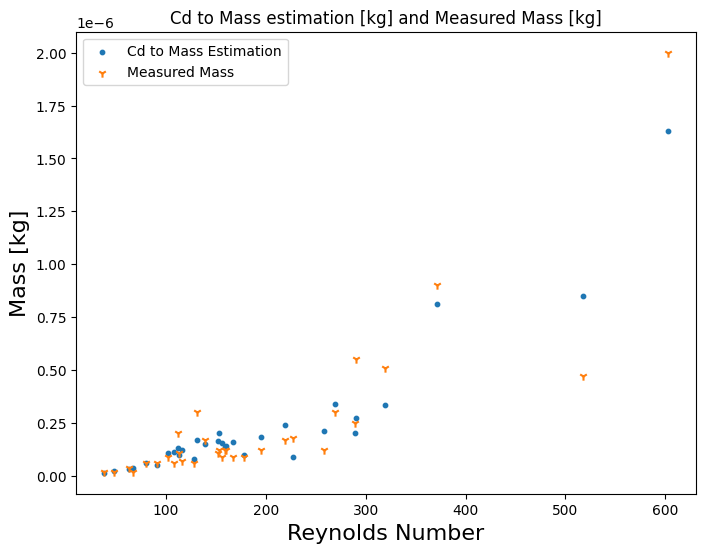

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(LH_test['Re_unscaled'], mass_estimation, s=10)
plt.scatter(LH_test['Re_unscaled'], LH_test['Mass [kg]'],marker="1")
plt.legend(['Cd to Mass Estimation','Measured Mass'])
plt.xlabel('Reynolds Number', fontsize=16)
plt.ylabel('Mass [kg]', fontsize=16)
plt.title('Cd to Mass estimation [kg] and Measured Mass [kg]')

Text(0.5, 1.0, 'Reference Mass [kg] vs Cd to Mass estimation [kg]')

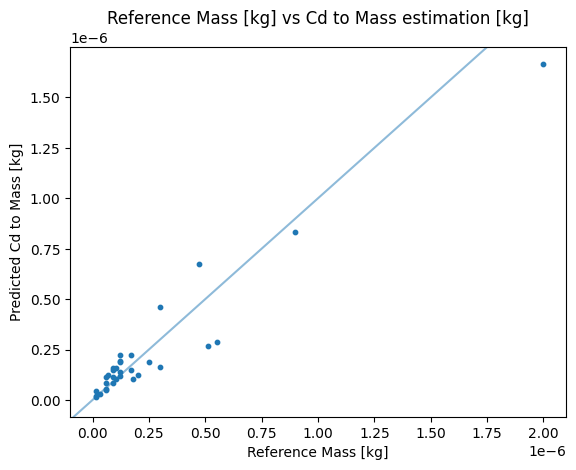

In [296]:
plt.scatter(LH_test['Mass [kg]'], mass_estimation, s = 10)
plt.xlabel('Reference Mass [kg]')
plt.ylabel('Predicted Cd to Mass [kg]')
plt.axline((0, 0), slope=1, alpha=0.5)
plt.title('Reference Mass [kg] vs Cd to Mass estimation [kg]')

In [297]:
print('Our Model (cd -> mass) MSE: ' + str(np.mean([abs(i-j)**2 for i,j in zip(mass_estimation, LH_test['Mass [kg]'])])))

print('Our Model (cd -> mass) RMSE: ' + str(np.sqrt(np.mean([(abs(i-j)**2) for i,j in zip(mass_estimation, LH_test['Mass [kg]'])]))))

RMSE = np.sqrt(np.sum([(abs(i-j)**2) for i,j in zip(mass_estimation, LH_test['Mass [kg]'])])/len(mass_estimation))
print('Our Model (cd -> mass) NRMSE:  ' + str(100*(RMSE / (np.mean(LH_test['Mass [kg]'])))))

Our Model (cd -> mass) MSE: 1.2179555528972636e-14
Our Model (cd -> mass) RMSE: 1.1036102359516531e-07
Our Model (cd -> mass) NRMSE:  46.71366096639403


### MASCDB TRANSFER LEARNING FROM LH SPLIT MODEL

In [47]:
class masc_low(torch.utils.data.Dataset):
    def __init__(self, low_X):

        self.RE = low_X['Re']
        self.shape = low_X['snowflake_class_id']
        self.PCA1 = low_X['KPCA1']
        self.PCA2 = low_X['KPCA2']
        self.PCA3 = low_X['KPCA3']
        self.PCA4 = low_X['KPCA4']
        self.PCA5 = low_X['KPCA5']
        self.y = low_X['Cd']
        self.id = low_X['id']

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        RE = torch.tensor(self.RE[idx], dtype=torch.float32)
        shape = torch.tensor(self.shape[idx], dtype=torch.float32)
        PCA1 = torch.tensor(self.PCA1[idx], dtype=torch.float32)
        PCA2 = torch.tensor(self.PCA2[idx], dtype=torch.float32)
        PCA3 = torch.tensor(self.PCA3[idx], dtype=torch.float32)
        PCA4 = torch.tensor(self.PCA4[idx], dtype=torch.float32)
        PCA5 = torch.tensor(self.PCA5[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        id = torch.tensor(self.id[idx], dtype=torch.float32)
        
       # return data, y
        return torch.tensor([RE, shape, PCA1, PCA2, PCA3, PCA4, PCA5]), y, id

class masc_high(torch.utils.data.Dataset):
    def __init__(self, high_X):

        self.RE = high_X['Re']
        self.shape = high_X['snowflake_class_id']
        self.PCA1 = high_X['KPCA1']
        self.PCA2 = high_X['KPCA2']
        self.PCA3 = high_X['KPCA3']
        self.PCA4 = high_X['KPCA4']
        self.PCA5 = high_X['KPCA5']
        self.y = high_X['Cd']
        self.id = high_X['id']

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        RE = torch.tensor(self.RE[idx], dtype=torch.float32)
        shape = torch.tensor(self.shape[idx], dtype=torch.float32)
        PCA1 = torch.tensor(self.PCA1[idx], dtype=torch.float32)
        PCA2 = torch.tensor(self.PCA2[idx], dtype=torch.float32)
        PCA3 = torch.tensor(self.PCA3[idx], dtype=torch.float32)
        PCA4 = torch.tensor(self.PCA4[idx], dtype=torch.float32)
        PCA5 = torch.tensor(self.PCA5[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        id = torch.tensor(self.id[idx], dtype=torch.float32)
        
        
       # return data, y
        return torch.tensor([RE, shape, PCA1, PCA2, PCA3, PCA4, PCA5]), y, id

loader_low = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/masc_models/masc_low_10k_testloader.pth', map_location=torch.device('cpu'))
loader_high = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/masc_models/masc_high_10k_testloader.pth', map_location=torch.device('cpu'))

modelLow = MLP5_low()
modelHigh = MLP5_high()

low = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_models/LH_low_5k_sch_dropout.model')
high = torch.load('/Users/cameronhudson/Documents/Masters/Research/Snow/LH_models/LH_high_5k_sch_dropout.model')
modelLow.load_state_dict(low)
modelHigh.load_state_dict(high)

modelCombined = CombinedModel(modelLow, modelHigh)

In [48]:
y_test_low = [dat.item() for data in loader_low for dat in data[1]]
y_test_high = [dat.item() for data in loader_high for dat in data[1]]
y_test = y_test_low + y_test_high

low_data = [dat for data in loader_low for dat in data[0]]
high_data = [dat for data in loader_high for dat in data[0]]

combined_data = low_data + high_data

y_test_ids_high = [dat.item() for data in loader_high for dat in data[2]]
y_test_ids_low = [dat.item() for data in loader_low for dat in data[2]]
y_test_ids = y_test_ids_low + y_test_ids_high

In [49]:
data = pd.read_csv('data/masc_KPCA_5_feature_filtered.csv')
data['snowflake_class_id'] = (data['snowflake_class_id']).astype(np.float32)
data['Re'] = (data['Re']).astype(np.float32)
data['KPCA1'] = (data['KPCA1']).astype(np.float32)
data['KPCA2'] = (data['KPCA2']).astype(np.float32)
data['KPCA3'] = (data['KPCA3']).astype(np.float32)
data['KPCA4'] = (data['KPCA4']).astype(np.float32)
data['KPCA5'] = (data['KPCA5']).astype(np.float32)
data['Cd'] = (data['Cd']).astype(np.float32)
data.rename(columns={'Unnamed: 0' : 'id'}, inplace=True)

data['Re_unscaled'] = data['Re']
scaler = StandardScaler()

data[['Re', 'KPCA1', 'KPCA2', 'KPCA3', 'KPCA4', 'KPCA5']] = scaler.fit_transform(data[['Re', 'KPCA1', 'KPCA2', 'KPCA3', 'KPCA4', 'KPCA5']])

masc_test = data.loc[y_test_ids]
masc_test.rename(columns={'id' : 'temp_id'}, inplace=True)
full_masc = pd.read_csv('/Users/cameronhudson/Documents/Masters/Research/Snow/data/mascdb_full_filtered.csv')
full_masc['Cd'] = (full_masc['Cd']).astype(np.float32)
full_masc.rename(columns={'Unnamed: 0' : 'temp_id'}, inplace=True)
masc_test = pd.merge(masc_test, full_masc, on='temp_id', how='left')

In [50]:
testing_data = masc_test[['Re_x', 'snowflake_class_id_x', 'KPCA1', 'KPCA2', 'KPCA3', 'KPCA4', 'KPCA5', 'Re_unscaled']]
testing_data = [torch.tensor(row.values) for _, row in testing_data.iterrows()]

y_pred = []
for i in testing_data:
    y_pred.append(modelCombined(i).item())

Text(0.5, 1.0, 'Locatelli and Hobbs Drag Prediction on MASCDB Test Dataset')

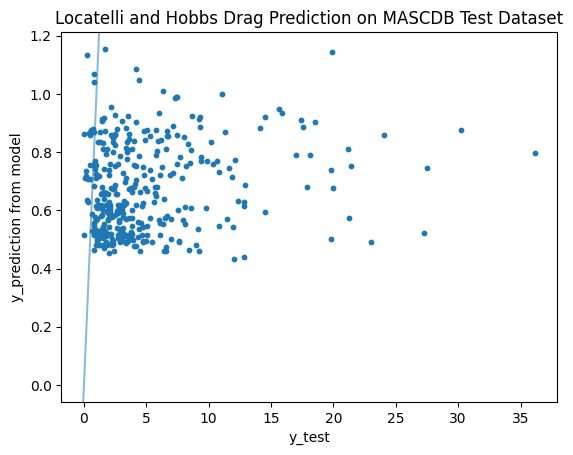

In [53]:
plt.scatter(y_test, y_pred, s=10)
plt.axline((0, 0), slope=1, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_prediction from model') # fe_5_e4"
plt.title('Locatelli and Hobbs Drag Prediction on MASCDB Test Dataset')

Text(0.5, 1.0, 'LH Dataset Drag Prediction vs Drag Coefficient on Test Dataset')

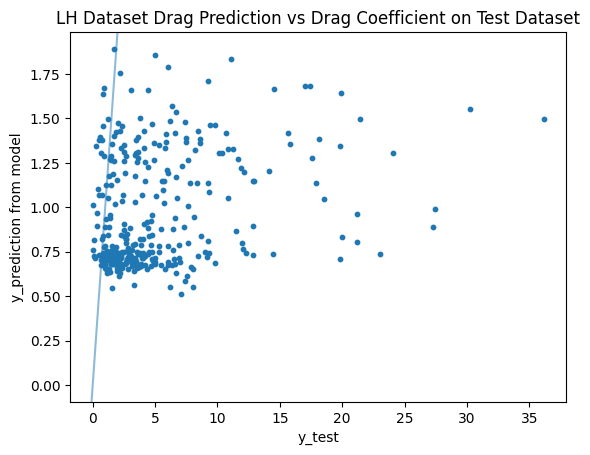

In [140]:
plt.scatter(y_test, y_pred, s=10)
plt.axline((0, 0), slope=1, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_prediction from model') # fe_5_e4"
plt.title('LH Dataset Drag Prediction vs Drag Coefficient on Test Dataset')

Text(0.5, 1.0, 'LH Prediction Model on Drag Error Graph')

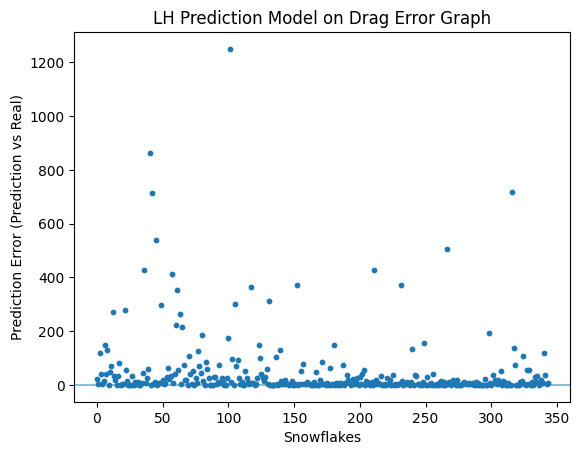

In [55]:
error = []
for i in range(len(y_test)):
    error.append(float(y_test[i] - y_pred[i])**2)

plt.scatter([i for i in range(len(error))], error, s=10)
plt.axline((0,0), slope=0, alpha=0.5)
plt.xlabel('Snowflakes')
plt.ylabel('Prediction Error (Prediction vs Real)')
plt.title('LH Prediction Model on Drag Error Graph')

In [145]:
C0HW = 0.35 # Mitchell 1996 C0 = 0.6 and delta0 = 5.83
del0HW = 8.0 # HW (2010) C0 = 0.35 and delta0 = 8.0
k = 0.5

CdHW_init = [C0HW * (1 + del0HW / np.sqrt(Re_val))**2 for Re_val in masc_test['Re_unscaled']]
CdHW = (masc_test['roundness']**k) * CdHW_init


In [147]:
masc_test

,temp_id,Re_x,Cd_x,snowflake_class_id_x,KPCA1,KPCA2,KPCA3,KPCA4,KPCA5,Re_unscaled,...,A_char,A_cross,A_length,CH_area,rho_air,visc_air,dyn_P,Cd_y,Re_y,CH_vol
0,0,-0.525131,5.465079,3.0,0.152521,0.472406,-0.701053,1.214377,-1.522683,153.724838,...,4.895890e-06,7.588630e-06,4.895890e-06,4.895890e-06,0.967048,0.000017,0.167176,10.547443,105.510145,NaN
1,1291,-1.001540,2.618247,2.0,1.358130,-0.180162,1.120305,1.457938,0.330118,74.095245,...,7.500000e-06,1.162500e-05,7.500000e-06,7.500000e-06,0.942041,0.000017,5.352509,0.340409,834.904974,NaN
2,1272,-1.167758,11.640262,2.0,0.937125,-0.964379,-1.087140,-1.864752,0.443299,46.312572,...,7.790323e-06,1.207500e-05,7.790323e-06,7.790323e-06,0.942041,0.000017,0.643678,3.452943,273.984283,NaN
3,1252,-0.719277,7.112171,4.0,1.285750,0.162051,1.518899,-0.074430,-0.923410,121.274170,...,1.379798e-06,1.379798e-06,1.379798e-06,1.379798e-06,0.942041,0.000017,1.089678,0.796004,120.513590,1.573939e-09
4,1111,-0.928151,2.517490,5.0,0.020539,1.816158,-0.563621,-1.343859,-1.102526,86.361839,...,8.022472e-07,8.022472e-07,8.022472e-07,8.022472e-07,0.949427,0.000017,0.303817,5.151803,57.536766,8.321283e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,21,0.029281,3.188891,4.0,1.464492,0.241848,0.254388,0.256121,-0.333858,246.392212,...,6.321429e-06,9.798214e-06,6.321429e-06,6.321429e-06,0.968148,0.000017,0.733547,3.253735,235.620660,NaN
340,66,-0.437045,11.473859,5.0,-1.264082,-0.514588,-0.356511,-0.648362,-1.001221,168.447906,...,3.935802e-06,6.100494e-06,3.935802e-06,3.935802e-06,0.934799,0.000017,0.539134,2.644448,159.611167,NaN
341,1080,-0.400110,6.670208,4.0,0.043155,0.016672,2.131107,1.558049,-0.376300,174.621460,...,2.694318e-06,4.176193e-06,2.694318e-06,2.694318e-06,0.963794,0.000017,0.238158,5.840078,85.682675,NaN
342,167,0.950580,2.833133,4.0,-0.903058,-0.235941,-0.204427,2.013141,-1.002025,400.383179,...,8.976744e-07,8.976744e-07,8.976744e-07,8.976744e-07,0.943840,0.000017,1.101831,0.833133,121.543689,1.129164e-09


Text(0.5, 1.0, 'LH Drag Prediction Model vs Reynolds Number w/ LH Split MLP Model on MASCDB')

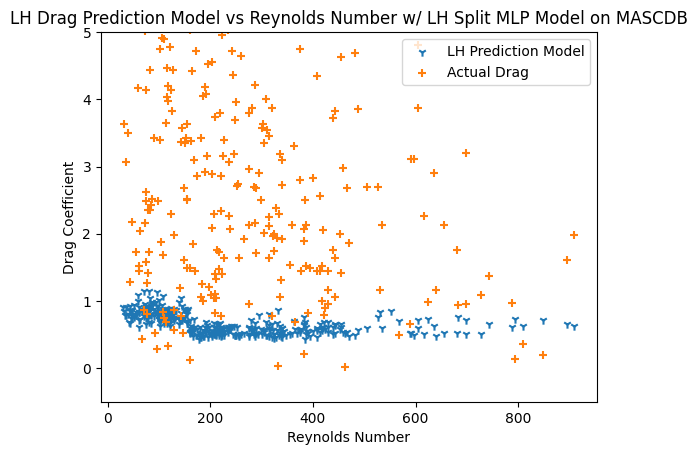

In [58]:
#plt.scatter(masc_test['Re_unscaled'], CdHW, s=10)
plt.scatter(masc_test['Re_unscaled'], y_pred,marker="1")
plt.scatter(masc_test['Re_unscaled'], masc_test['Cd_x'], marker='+')
plt.legend(['LH Prediction Model', 'Actual Drag'])
plt.xlabel('Reynolds Number')
plt.ylabel('Drag Coefficient')
plt.ylim((-.5,5))
plt.title('LH Drag Prediction Model vs Reynolds Number w/ LH Split MLP Model on MASCDB')

In [149]:
percent_error = [abs(i-j)**2 for i,j in zip(y_pred, y_test)]
#torch.mean(torch.stack(percent_error)) # % error
np.mean(percent_error)

44.5032403152567

In [150]:
np.mean([[abs(i-j)**2 for i,j in zip(CdHW, y_test)]])


46.91012283492549

In [56]:
print('Our Model: ' + str(np.mean([abs(i-j)**2 for i,j in zip(y_pred, y_test)])))

Our Model: 47.493978679451246
